In [9]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt


# Parameters
start_year = 1997
end_year = 2022 
top_n = 10  # Number of top increases and decreases to display

# Load data
data_folder = 'Data_clean/'
primary_categories_path = data_folder + 'CPI_primary_categories.csv'
primary_categories_codebook_path = data_folder + 'CPI_primary_categories_codebook_english.csv'
primary_categories = pd.read_csv(primary_categories_path)
primary_categories_codebook = pd.read_csv(primary_categories_codebook_path)

# Clean only the 'Item' column and convert to integer
primary_categories['Item'] = primary_categories['Item'].map(lambda x: str(x)[:6] if isinstance(x, (int, float, str)) else x)
primary_categories['Item'] = primary_categories['Item'].astype(int)

# Create a dictionary mapping codes to descriptions from the codebook
code_to_description = dict(zip(primary_categories_codebook['Item'], primary_categories_codebook['Description']))

# Add description column by mapping codes to their descriptions
primary_categories['Description'] = primary_categories['Item'].map(code_to_description)

# Reorder columns to place Description right after Item
columns = primary_categories.columns.tolist()
columns.remove('Description')
item_index = columns.index('Item')
columns.insert(item_index + 1, 'Description')
primary_categories = primary_categories[columns]

# Filter data to keep only observations between start_year and end_year inclusive
primary_categories = primary_categories[(primary_categories['Year'] >= start_year) & (primary_categories['Year'] <= end_year)]

# Calculate the average of months 1 to 12 for each row
primary_categories['Yearly_Average'] = primary_categories[[str(month) for month in range(1, 13)]].mean(axis=1)

# Keep only yearly average for each year
primary_categories = primary_categories[['Item', 'Description', 'Year', 'Yearly_Average']]

# Create a new DataFrame with Item and Description as index
pivot_df = primary_categories.pivot(index=['Item', 'Description'], columns='Year', values='Yearly_Average')

# Reset index to make Item and Description regular columns
pivot_df = pivot_df.reset_index()

# Rename columns to be more descriptive
pivot_df.columns.name = None
year_columns = {year: f'{year}' for year in range(start_year, end_year + 1)}
pivot_df = pivot_df.rename(columns=year_columns)

# Replace primary_categories with the new pivoted DataFrame
primary_categories = pivot_df

# Drop rows with any missing values across all year columns
primary_categories = primary_categories.dropna(subset=[str(year) for year in range(start_year, end_year + 1)])

# Calculate the difference between end_year and start_year values
primary_categories[f'Change_{start_year}_{end_year}'] = primary_categories[str(end_year)] - primary_categories[str(start_year)]

# Get the top N largest increases and decreases
top_increases = primary_categories.nlargest(top_n, f'Change_{start_year}_{end_year}')
top_decreases = primary_categories.nsmallest(top_n, f'Change_{start_year}_{end_year}')

# Display the top N increases as tables
top_increases[f'Change_{start_year}_{end_year}'] = top_increases[f'Change_{start_year}_{end_year}'].round(2)
top_decreases[f'Change_{start_year}_{end_year}'] = top_decreases[f'Change_{start_year}_{end_year}'].round(2)
print(f'Top {top_n} Price Increases from {start_year} to {end_year}')
print(tabulate(top_increases[['Description', f'Change_{start_year}_{end_year}']], headers='keys', tablefmt='pretty'))

[NbConvertApp] Converting notebook CPI_top_changes.ipynb to pdf
[NbConvertApp] Support files will be in CPI_top_changes_files/
[NbConvertApp] Making directory ./CPI_top_changes_files
[NbConvertApp] Writing 20883 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 315704 bytes to CPI_top_changes.pdf
Top 10 Price Increases from 1997 to 2022
+-----+--------------------------------------+------------------+
|     |             Description              | Change_1997_2022 |
+-----+--------------------------------------+------------------+
| 65  | Kerosene and Diesel for Home Heating |      90.09       |
| 145 |        Cigarettes and Tobacco        |      74.15       |
| 64  |        Gas for Household Use   

/var/folders/m9/b19pphns6hqc2k27c3qtngn40000gn/T/ipykernel_66125/777276121.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_categories[f'Change_{start_year}_{end_year}'] = primary_categories[str(end_year)] - primary_categories[str(start_year)]


In [10]:
# Show top decreases
print('\n')
print(f'Top {top_n} Price Decreases from {start_year} to {end_year}')
print(tabulate(top_decreases[['Description', f'Change_{start_year}_{end_year}']], headers='keys', tablefmt='pretty'))
print('\n')



Top 10 Price Decreases from 1997 to 2022
+-----+-----------------------------------+------------------+
|     |            Description            | Change_1997_2022 |
+-----+-----------------------------------+------------------+
| 78  |        Bedding and Towels         |     -513.53      |
| 124 |              Hobbies              |     -240.55      |
| 106 |         Women's Footwear          |     -214.24      |
| 92  |         Women's Outerwear         |     -163.53      |
| 104 |             Footwear              |     -152.34      |
| 107 |        Children's Footwear        |     -140.91      |
| 105 |          Men's Footwear           |     -121.09      |
| 93  | Children's and Infants' Outerwear |     -103.28      |
| 125 |    Toys for Children and Youth    |      -93.69      |
| 89  |       Clothing and Footwear       |      -84.94      |
+-----+-----------------------------------+------------------+




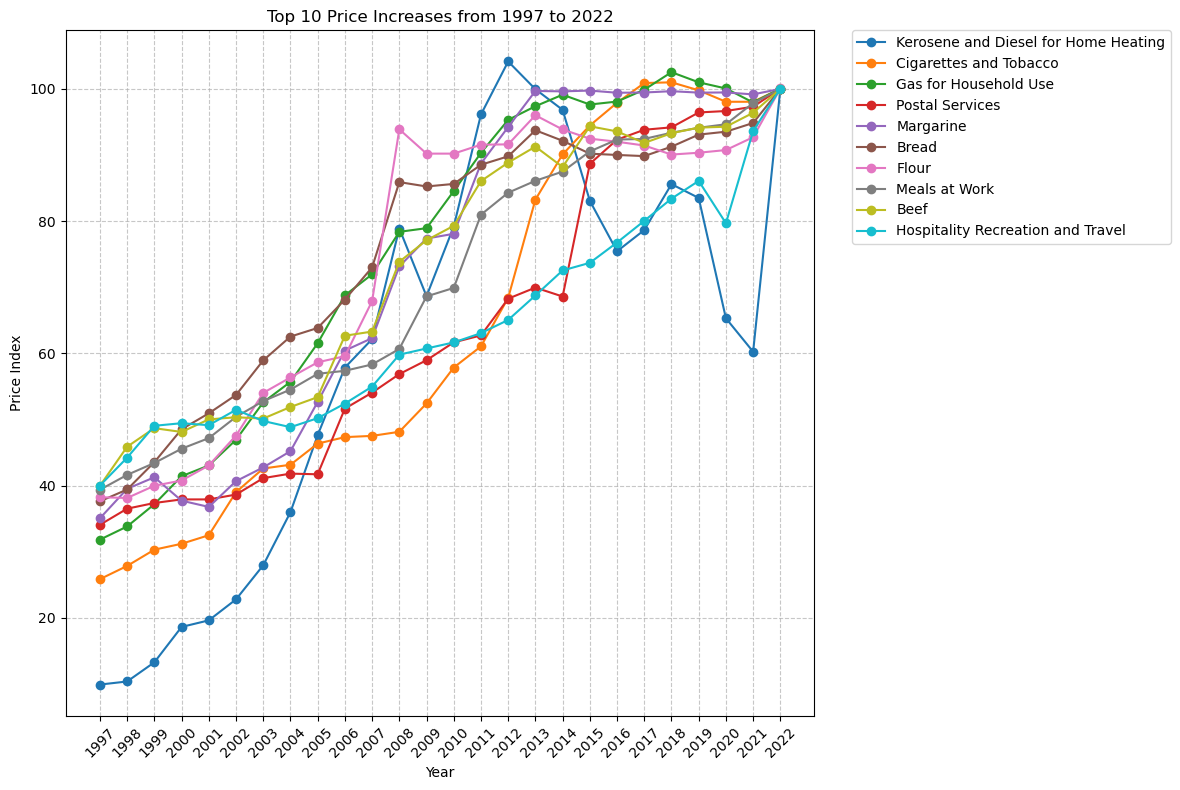

In [11]:
# Create a plot for the top N increases
plt.figure(figsize=(12, 8))
for idx, row in top_increases.iterrows():
    yearly_values = row[[str(year) for year in range(start_year, end_year + 1)]].values
    plt.plot(range(start_year, end_year + 1), yearly_values, marker='o', label=row['Description'])

plt.title(f'Top {top_n} Price Increases from {start_year} to {end_year}')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(range(start_year, end_year + 1), rotation=45)
plt.tight_layout()
plt.show()

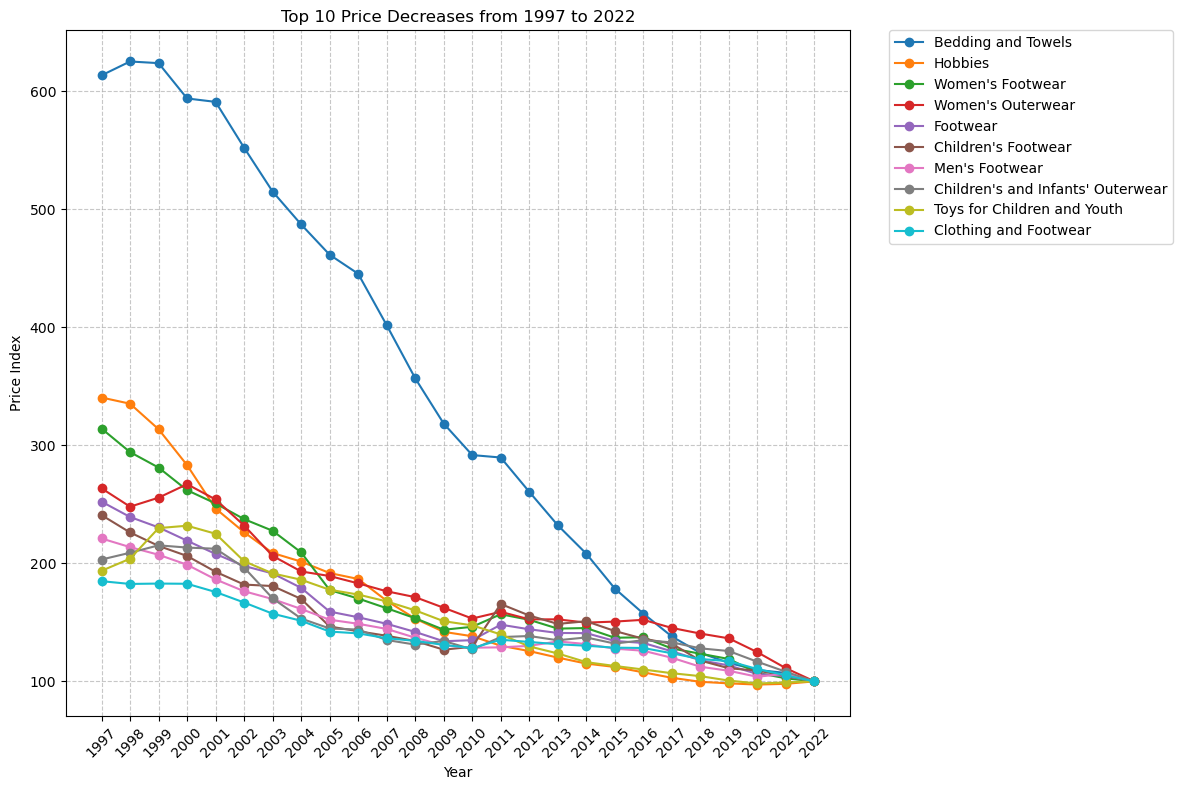

In [12]:
# Create a plot for the top N decreases
plt.figure(figsize=(12, 8))
for idx, row in top_decreases.iterrows():
    yearly_values = row[[str(year) for year in range(start_year, end_year + 1)]].values
    plt.plot(range(start_year, end_year + 1), yearly_values, marker='o', label=row['Description'])

plt.title(f'Top {top_n} Price Decreases from {start_year} to {end_year}')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(range(start_year, end_year + 1), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Export to pdf
!jupyter nbconvert --to pdf --no-input CPI_top_changes.ipynb

0